## Instructions {-}

1. This is the template you may use to submit your code and report for the prediction problems on Kaggle.

2. You may modify the template if you deem fit, but it should have the information asked below.

## A.1) Data cleaning

Mention the data cleaning steps taken to prepare your data for developing the model. This may include imputing missing values, dealing with outliers, combining levels of categorical variable(s), etc.

* Put your data cleaning/preparation code with comments here
* The code should begin from reading the train data
* The code should end when you obtain the data used to develop the model in A.4

In [7]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import impute
import itertools as it
import time as time
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

data = pd.read_csv('train.csv')

# Log transformation of response variable
y = np.log(data.y)
X = data.drop('y', axis=1)


# Drop columns with >5% NaN
inst = X.shape[0]
nan_col = [col for col in X if (X[col].isna().sum() / inst > 0.05)]
X = X.drop(nan_col, axis=1)


#Impute NaN values from remaining columns using KNNImputer
imputer = impute.KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X)

## A.2) Exploratory data analysis

Mention any major insights you obtained from the data, which you used to develop the model. PLease put your code or visualizations here if needed.

- Skewed response variable
- 11 columns with 0 variance
- Many instances of highly correlated features
- Many columns with little correlation with response variable

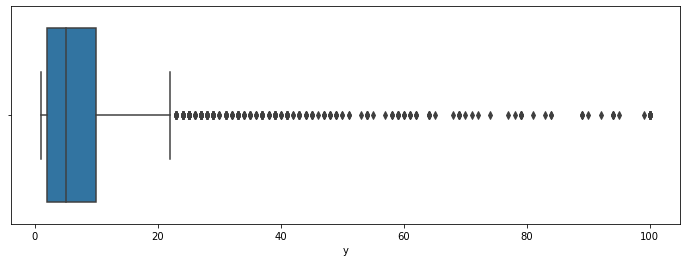

In [4]:
# Response distribution
np.warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data.y)

In [8]:
# Identifying zero variance columns
X = pd.DataFrame(X)
zero_var = []

print(X.shape)

res=[]
for col in X:
     if len(X[col].unique()) == 1:
        res.append(col)

print('Columns dropped:', len(res))

(5380, 727)
Columns dropped: 11


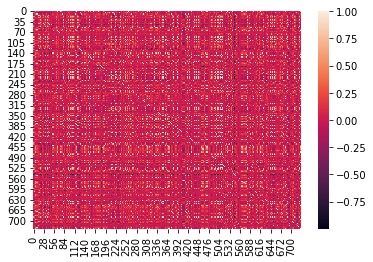

In [10]:
#Many light elements off the diagonal signify high correlations
sns.heatmap(X.corr())

In [15]:
#4 58 features with less than 0.01 correlation with y
(X.corrwith(y) < 0.01).sum()

486

## A.3) Feature selection/reduction

Mention the steps for feature selection/reduction. PLease put your code or visualizations here if needed.

- Delete 0 variance columns
- Select features via comparison to randomly generated columns

In [ ]:
# STEP 1
# Delete 0 variance columns
X = pd.DataFrame(X)
zero_var = []

print(X.shape)

res=[]
for col in X:
     if len(X[col].unique()) == 1:
        res.append(col)
        X = X.drop(col, axis=1)

print('Columns dropped:', len(res))
# 11 columns with only 1 value

In [ ]:
# STEP 2
# Feature Selection - compare feature importances to random columns
np.warnings.filterwarnings('ignore')

#Set random columns to assist search for non-important columns
from numpy import random
random.seed(seed=0)
for i in range(X.shape[1]):
  random = pd.Series(np.random.randn(X.shape[0]))
  X[f'random{i}'] = random

#Use RandomForestRegressor to find feature_importances
X.columns = X.columns.astype(str)
rf = RandomForestRegressor().fit(X,y)

imp = rf.feature_importances_
importances = pd.DataFrame({'feature':X.columns, 'importance':imp})

# Find importance of most important random column
random_imp = importances.loc[range(717, 1432), 'importance'].max()

# Delete columns from the original set if they are less important than max random importance found above
selected_predictors = importances[importances['importance'] > random_imp]['feature'].astype(str).tolist()

X = X.loc[:,selected_predictors]
#Down to 62 predictors after importance selection

# X is our final training dataset with 62 remaining features

## A.4) Developing the model

Mention the logical sequence of steps taken to obtain the final model. 

- RandomForest
- XGBoost
- CatBoost
- Ensemble

In [ ]:
# MODEL 1
# RandomForest
# Selected as a complement to future boosting models. Seeking to get a non-boosting
# approach to model the response variable to improve ensemble variety.

# Refined grid search via iterations of parameter grids
params = {'max_depth':[20, 25, 30],
          'max_leaf_nodes':[450, 500, 550],
          'bootstrap': [True],
         'max_features': [0.7, 0.8, 0.9, 1]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

rf = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1, bootstrap=True, n_estimators=100), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring = 'neg_mean_squared_error')

rf.fit(X, y)

print('Best Parameters : ',rf.best_params_)

# Giving final model
tuned_rf = RandomForestRegressor(random_state=1, n_jobs=-1, bootstrap=True, n_estimators=100,
                                 max_depth= 25, max_features= 0.8, max_leaf_nodes= 500).fit(X,y)

In [ ]:
# MODEL 2
# XGBoost
# Selected based on speed of implimentation and claim of higher accuracy among boosting models.

# Refined grid search via iterations of parameter grids
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                             n_iter=100,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                             scoring = 'neg_mean_squared_error')
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)

# Giving final model
xg = xgb.XGBRegressor(random_state=1, subsample= 0.5, reg_lambda= 1, n_estimators= 500, 
                       max_depth= 4, learning_rate= 0.05, gamma= 0, colsample_bytree= 1.0).fit(X,y)

In [ ]:
# MODEL 3
# CatBoost
# Selected based on recomendations from CampusWire posts

# Grid searh via parameter grid iterations and intuition from xg boost optimal parameters
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'subsample': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1, verbose=False),                                                       
                             param_distributions = param_grid, n_iter = 100,
                             verbose = 1,random_state = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)

#Giving Final Model
model_cat = CatBoostRegressor(random_state=1, verbose=False, subsample=0.75, reg_lambda=10, num_leaves=31,
                              n_estimators=1000, max_depth=4, learning_rate=0.1).fit(X,y)

In [ ]:
# MODEL 4 - FINAL MODEL
# Individual models moderately successful with kaggle submissions

# Now, create ensemble with StackingRegressor to improve on individual results
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

en = StackingRegressor(estimators = [('cat', model_cat), ('xg', xg), ('rf', tuned_rf)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X,y)

## A.5) Discussion

Please provide details of the models/approaches you attempted but encountered challenges or unfavorable outcomes. If feasible, kindly explain the reasons behind their ineffectiveness or lack of success. Additionally, highlight the significant challenges or issues you encountered during the process.

#### Lasso
Lasso was initially useful of achieveing an RMSE of ~9 by itself. As I began to use more complicated methods of feature selection, however, the usefulness of lasso became less pronounced. When implimented in ensemble models, it tended to reduce performance. While intended to add a linear model into the mix of the ensemble, it did not perform well enough to be included in the final model. 

#### Bagged MARS / Bagged DecisionTrees
Initially selected based on recomendations from the campuswire, Bagged MARS models did not achieve good performance results with my method of feature selection. Though attempts were made to impliment it into the final ensemble, it was cut well before the final submission due to a lack of predictive power.

#### Neural Network
A neural network was intended to add a more complex intepretation of feature variation to the final ensemble. However, possibly due to a lack of experience in tuning, it was difficult to reduce overfitting to a point where the model would have been productive in an ensemble. The lack of accuracy could also be due to a relatively small number of training observations.

## A.6) Conclusion

* Do you feel that you gain valuable experience, skills, and/or knowledge? If yes, please explain what they were. If no, please explain.
* What are things you liked/disliked about the project and/or work on the project?

While this project was certainly frustrating at times to complete independently, I do feel that it was valuable experience in curating an ensemble model with a variety of base models that I had been exposed to before. It helped me to understand that even if a model did not have extensive predictive power by itself (say lasso), it could be capturing a totally different type of variation from more successful models. Thus, a variety of approaches to modeling variation is neccesary in a successful ensemble solution to a large dataset like this one.

This was the most impactful part of the project in terms of my experience. Secondarily, experience with google colab VM and heavy modeling was both frustrating and good experience. I am thankful for the opportunity to work in the cloud setting, though more in-depth explinations of how to get the machine started seems neccesary.

Overall, this was a very involved project that felt overwhelming at times for an individual student. It felt right to have this as a 10 week project in 390 with time to do EDA as opposed to the shorter 303-3 timeline. 

## Please make sure your github repo has all the code and  ensure that your code is capable of reproducing the outcomes you have submitted. It is important to avoid any form of academic misconduct or cheating by using your peer's submission file

Use Model_Final.ipynb to replicate results